In [11]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import ReceptiveField
import pickle
import numpy as np
import  modin.pandas as pd
import os
from tqdm import tqdm
from NRC import NRC,recordModule
from matplotlib.pyplot import MultipleLocator
from matplotlib.gridspec import GridSpec
from utils import returnSpec
from distributed import Client
client = Client()

Perhaps you already have a cluster running?
Hosting the HTTP server on port 55473 instead


In [12]:
srate = 250
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

rep  = wholeset[0]
chnNames = ['PZ', 'PO5', 'POZ', 'PO3', 'PO4',
            'PO6', 'PO7', 'PO8', 'O1', 'OZ', 'O2']
chnINX = [wholeset[0]['channel'].index(i) for i in chnNames]

X = rep['wn']['X'][:, chnINX]
y = rep['wn']['y']
S = rep['wn']['STI']

_class = np.unique(y)
rep['name']
X.shape

(960, 11, 250)

In [13]:
import random
targetNUM=40
random.seed(0)
picked = random.sample(np.unique(y).tolist(), targetNUM)

X_picked = np.concatenate([X[y == i] for i in picked])
y_picked = np.concatenate([y[y == i] for i in picked])

In [16]:
score = []
from sklearn.model_selection import StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(n_splits=6, test_size=1/6, random_state=42)

for cv, (train_index, test_index) in tqdm(enumerate(stratSplit.split(X_picked, y_picked))):
    X_train, X_test = X_picked[train_index], X_picked[test_index]
    # S_train, S_test = S[train_index], S[test_index]
    y_train, y_test = y_picked[train_index], y_picked[test_index]

    from spatialFilters import *
    winLEN = 0.3
    model = TDCA(winLEN=winLEN,lag=35,srate=srate,montage=targetNUM,n_band=5,n_components=1)
    model.fit(X_train,y_train)

    # break
    score.append(model.score(X_test,y_test))

6it [00:09,  1.63s/it]


In [17]:
score

[0.95, 0.975, 0.95, 0.95, 0.875, 0.95]

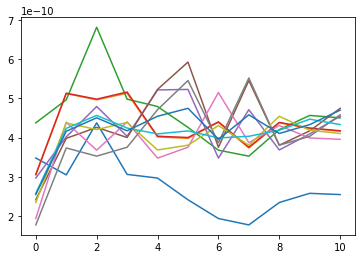

In [11]:
hb = model.Hb
Sb = np.dot(hb,hb.T)
plt.plot(Sb)

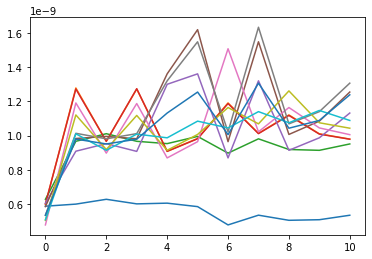

In [14]:
hw = model.Hw
Sw = np.dot(hw, hw.T)
plt.plot(Sw)

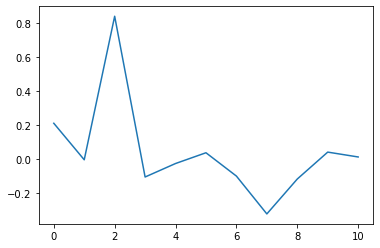

In [15]:
C = np.linalg.inv(Sw).dot(Sb)
plt.plot(C[:,:1])

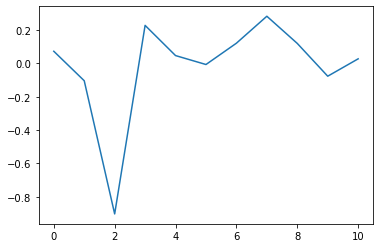

In [16]:
filters = np.squeeze(model.filters)
plt.plot(filters)